In [1]:
import umap
import torch
from torch.functional import F
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm

from common import h5dataset, model_dnn

c:\Users\sollb\Documents\fhnw\ip5\IP5-Jass-AI\training\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET_PATH = '../log_parser/dataset/flat_playing.hdf5'
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}")

MODLE_PATH = './models/'
if not os.path.exists(MODLE_PATH):
    os.makedirs(MODLE_PATH)


In [3]:
BATCH_SIZE = 256
NUM_ACTIONS = 9
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
dataset = h5dataset.H5Dataset(DATASET_PATH)
train_dataset, val_dataset = dataset.split(0.999)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)


# Load model
model_gan_untrained = model_dnn.ModelDNN(
    "JassPlayGenUntrained",
    input_size=72,
    embedding_size=13,
    hidden_size=[1024, 512, 256, 128],
    output_size=9,
)
model_gan_untrained.to(device)

model_gan = model_dnn.ModelDNN(
    "JassPlayGen",
    input_size=72,
    embedding_size=13,
    hidden_size=[1024, 512, 256, 128],
    output_size=9,
)
model_gan.load_state_dict(torch.load(os.path.join(MODLE_PATH, 'play_gan', 'JassGanGen_1024_512_256_128_dnn.pth')))
model_gan.to(device)
model_gan.eval()



model_sl = model_dnn.ModelDNN(
    "JassPlaySL",
    input_size=72,
    embedding_size=13,
    hidden_size=[512, 256, 128],
    output_size=9,
)

model_sl.load_state_dict(torch.load(os.path.join(MODLE_PATH, 'play', 'JassPlay_512_256_128_dnn.pth')))
model_sl.to(device)
model_sl.eval()


ModelDNN(
  (embedding): Embedding(37, 13)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=936, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=9, bias=True)
  )
)

In [4]:
# Containers
def create_state_action(model, loader):
    fake_combined, real_combined, real_labels, fake_labels = [], [], [], []
    model.eval()
    with torch.no_grad():
        for state, action in loader:
            state, action = state.to(device), action.to(device)

            # predict actions with THIS model
            logits = model(state)
            fake_actions = logits.argmax(dim=1)

            # embed state with THIS model
            em_state = model.embedding(state)

            # your slicing
            em_state = torch.cat([em_state[:, 32:42], em_state[:, 71:72]], dim=1)

            em_fake_actions = em_state.gather(1, fake_actions.view(-1,1).unsqueeze(-1).expand(-1,-1,em_state.size(2))).squeeze(1)
            em_real_actions = em_state.gather(1, action.view(-1,1).unsqueeze(-1).expand(-1,-1,em_state.size(2))).squeeze(1)

            real_labels_batch = state.gather(1, (action + 32).view(-1,1)) - 1
            fake_labels_batch = state.gather(1, (fake_actions + 32).view(-1,1)) - 1

            em_state = em_state.view(em_state.size(0), -1)

            fake_combined.append(torch.cat([em_state.cpu(), em_fake_actions.cpu()], dim=1))
            real_combined.append(torch.cat([em_state.cpu(), em_real_actions.cpu()], dim=1))
            real_labels.append(real_labels_batch.cpu())
            fake_labels.append(fake_labels_batch.cpu())

    fake_combined = torch.cat(fake_combined, dim=0)
    real_combined = torch.cat(real_combined, dim=0)

    return fake_combined.numpy(), fake_labels, real_combined.numpy(), real_labels

gan_fake, gan_fake_labels, gan_real, gan_real_labels = create_state_action(model_sl, val_loader)
gan_untrained_fake, gan_untrained_fake_labels, gan_untrained_real, gan_untrained_real_labels = create_state_action(model_gan_untrained, val_loader)


In [ ]:


X_trained  = np.vstack([gan_fake, gan_real])
X_untrained = np.vstack([gan_untrained_fake, gan_untrained_real])
X_all = np.vstack([X_trained, X_untrained])

class UMAPProgress(umap.UMAP):
    def fit(self, X, y=None):
        tqdm.write("Fitting UMAP...")
        return super().fit(X, y)

    def transform(self, X):
        tqdm.write("Transforming with UMAP...")
        return super().transform(X)

# Example usage
reducer = UMAPProgress(n_neighbors=15, min_dist=0.05, n_components=2, random_state=SEED)

with tqdm(total=2, desc="UMAP pipeline") as pbar:
    reducer.fit(X_all)
    pbar.update(1)
    emb_trained   = reducer.transform(X_trained)
    pbar.update(1)
    emb_untrained = reducer.transform(X_untrained)

c:\Users\sollb\Documents\fhnw\ip5\IP5-Jass-AI\training\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


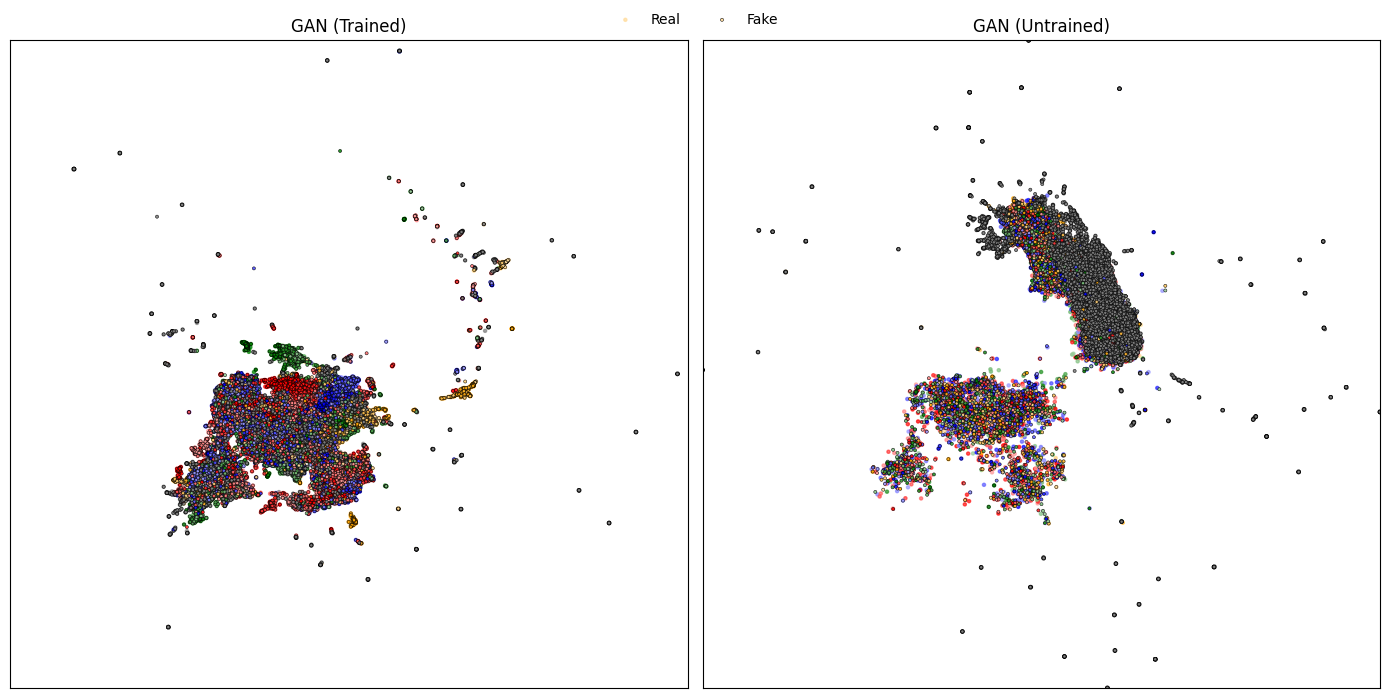

In [14]:

def generate_suit_colormap():
    # Define base colors for each suit
    suit_colors = {
        0: "#FF0000",  # Red (Suit 0)
        1: "#0000FF",  # Blue (Suit 1)
        2: "#008000",  # Green (Suit 2)
        3: "#FFA500"   # Orange (Suit 3)
    }

    # Generate a colormap where higher cards are lighter
    colormap = {}
    for suit in range(4):
        base_color = mcolors.to_rgb(suit_colors[suit])
        for card in range(9):
            lightness = 0.4 + 0.6 * (card / 8)  # Card 0 -> 0.4, Card 8 -> 1.0
            light_color = tuple(1 - (1 - c) * lightness for c in base_color)
            colormap[suit * 9 + card] = light_color

    return colormap

# --- build label arrays in the SAME order as the stacked X ---
gan_fake_labels_flat = torch.cat(gan_fake_labels, dim=0).squeeze(1).cpu().numpy()
gan_real_labels_flat = torch.cat(gan_real_labels, dim=0).squeeze(1).cpu().numpy()
labels_trained = np.concatenate([gan_fake_labels_flat, gan_real_labels_flat])

gan_untrained_fake_labels_flat = torch.cat(gan_untrained_fake_labels, dim=0).squeeze(1).cpu().numpy()
gan_untrained_real_labels_flat = torch.cat(gan_untrained_real_labels, dim=0).squeeze(1).cpu().numpy()
labels_untrained = np.concatenate([gan_untrained_fake_labels_flat, gan_untrained_real_labels_flat])

# fake masks match the stack order: [fake, real]
is_fake_mask_trained = np.r_[np.ones(len(gan_fake), dtype=bool),
                             np.zeros(len(gan_real), dtype=bool)]
is_fake_mask_untrained = np.r_[np.ones(len(gan_untrained_fake), dtype=bool),
                               np.zeros(len(gan_untrained_real), dtype=bool)]

def _contrast_overlay(ax, emb, fake_mask, title, alpha_val=0.5):
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])

    # Combine real & fake into one scatter call
    # Colors array: blue for real, red for fake
    colors = np.zeros((emb.shape[0], 4))  # RGBA
    colors[~fake_mask] = [0, 0, 1, alpha_val]  # blue, alpha
    colors[fake_mask]  = [1, 0, 0, alpha_val]  # red, alpha

    ax.scatter(emb[:, 0], emb[:, 1], s=8, c=colors)


def plot_trained_untrained_colored(
    emb1, labels1, fake_mask1,
    emb2, labels2, fake_mask2,
    title1="GAN (Trained)", title2="GAN (Untrained)"
):
    colormap = generate_suit_colormap()
    default_rgb = (0.5, 0.5, 0.5)

    labels1 = labels1.astype(int)
    labels2 = labels2.astype(int)

    colors1 = np.array([colormap.get(l, default_rgb) for l in labels1], dtype=float)
    colors2 = np.array([colormap.get(l, default_rgb) for l in labels2], dtype=float)

    # Shared limits
    all_x = np.concatenate([emb1[:, 0], emb2[:, 0]])
    all_y = np.concatenate([emb1[:, 1], emb2[:, 1]])
    xlim = (all_x.min(), all_x.max())
    ylim = (all_y.min(), all_y.max())

    fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)

    def _scatter(ax, emb, colors, fake_mask, title):
        # Real
        ax.scatter(emb[~fake_mask, 0], emb[~fake_mask, 1],
                   s=5, alpha=0.7, color=colors[~fake_mask], label="Real")
        # Fake (black border)
        ax.scatter(emb[fake_mask, 0], emb[fake_mask, 1],
                   s=5, alpha=0.9, color=colors[fake_mask],
                   edgecolors='black', linewidths=0.4, label="Fake")
        ax.set_title(title)
        ax.set_xlim(xlim); ax.set_ylim(ylim)
        ax.set_xticks([]); ax.set_yticks([])

    _scatter(axes[0], emb1, colors1, fake_mask1, title1)
    _scatter(axes[1], emb2, colors2, fake_mask2, title2)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2, frameon=False)

    plt.tight_layout()
    plt.show()


# Call it
plot_trained_untrained_colored(
    emb_trained,   labels_trained,   is_fake_mask_trained,
    emb_untrained, labels_untrained, is_fake_mask_untrained,
    "GAN (Trained)", "GAN (Untrained)"
)




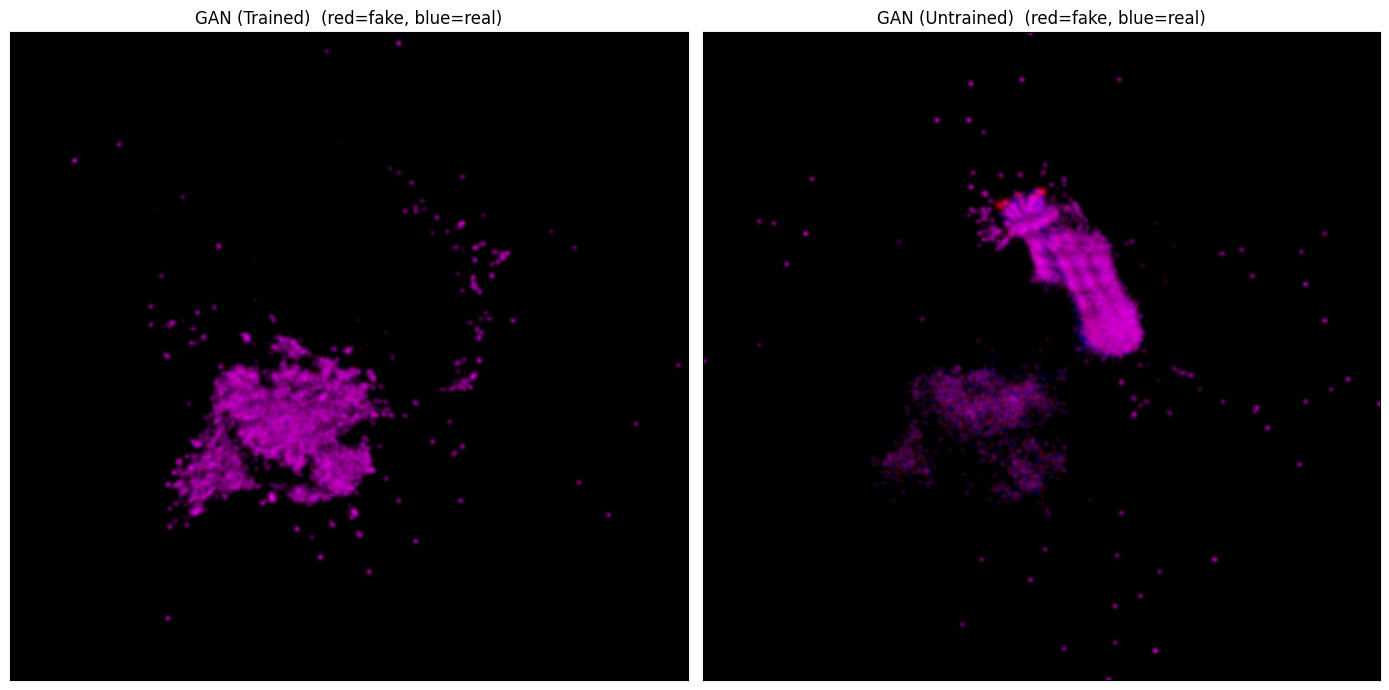

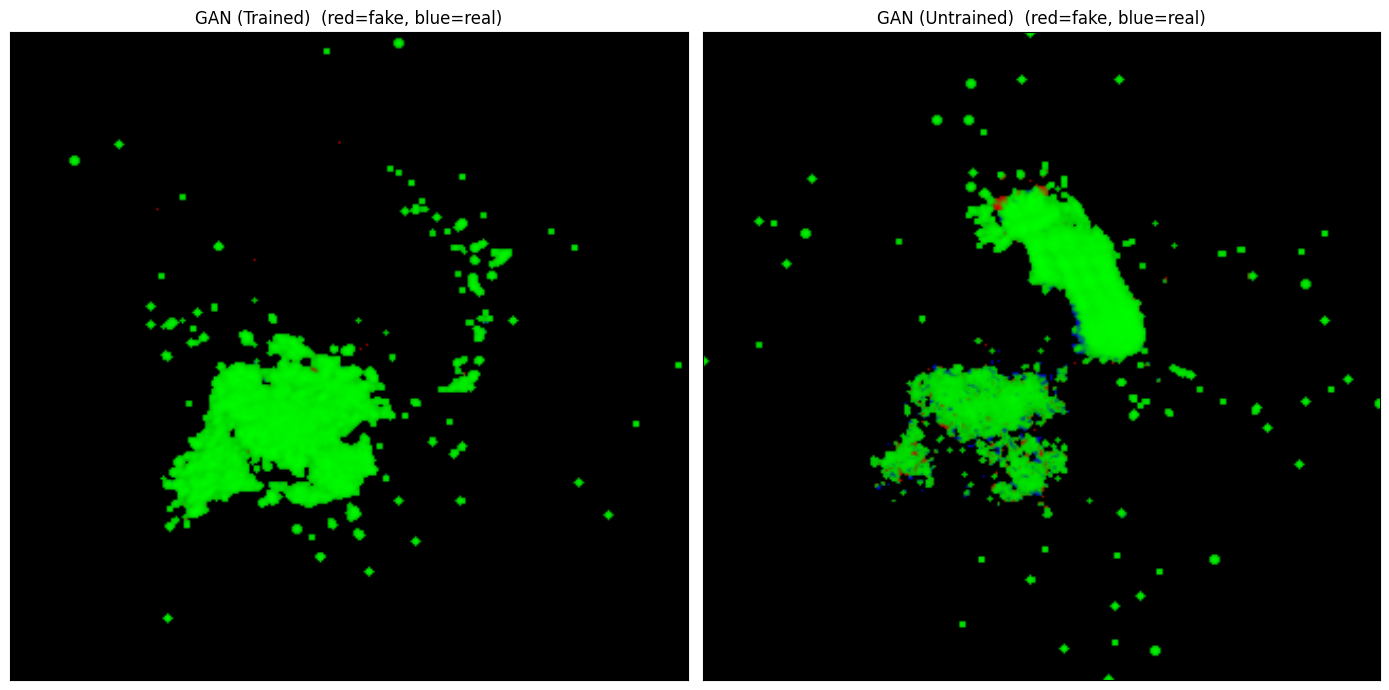

In [26]:
from scipy.ndimage import gaussian_filter


def plot_density_overlap(
    emb1, fake_mask1, emb2, fake_mask2,
    title1="GAN (Trained)", title2="GAN (Untrained)",
    bins=300, sigma=0.8,         # reduce sigma to avoid bleeding
    normalize="joint",           # "joint" prevents both channels pegging to 1
    log_scale=True, gamma=0.8,   # enhance low densities
    mode="blend",                # "blend" (purple) or "dominance"
    mask_low=0.03                # mask bins with tiny total density (0..1)
):
    # shared limits
    all_x = np.r_[emb1[:,0], emb2[:,0]]
    all_y = np.r_[emb1[:,1], emb2[:,1]]
    xlim = (all_x.min(), all_x.max()); ylim = (all_y.min(), all_y.max())

    def _hist_pair(emb, fake_mask):
        Hf, xedges, yedges = np.histogram2d(
            emb[fake_mask,0], emb[fake_mask,1], bins=bins, range=[xlim, ylim]
        )
        Hr, *_ = np.histogram2d(
            emb[~fake_mask,0], emb[~fake_mask,1], bins=bins, range=[xlim, ylim]
        )
        if sigma and sigma > 0:
            Hf = gaussian_filter(Hf, sigma=sigma)
            Hr = gaussian_filter(Hr, sigma=sigma)
        if log_scale:
            Hf = np.log1p(Hf)
            Hr = np.log1p(Hr)
        return Hf, Hr

    Hf1, Hr1 = _hist_pair(emb1, fake_mask1)
    Hf2, Hr2 = _hist_pair(emb2, fake_mask2)

    # normalization
    if normalize == "joint":
        m = max(Hf1.max(), Hr1.max(), Hf2.max(), Hr2.max(), 1e-12)
        Hf1 /= m; Hr1 /= m; Hf2 /= m; Hr2 /= m
    else:
        Hf1 /= max(Hf1.max(), 1e-12); Hr1 /= max(Hr1.max(), 1e-12)
        Hf2 /= max(Hf2.max(), 1e-12); Hr2 /= max(Hr2.max(), 1e-12)

    # gamma
    if gamma != 1.0:
        Hf1 = Hf1**gamma; Hr1 = Hr1**gamma
        Hf2 = Hf2**gamma; Hr2 = Hr2**gamma

    def _blend_img(Hf, Hr):
        # mask very low totals to avoid purple haze from smoothing
        T = Hf + Hr
        if mask_low is not None and mask_low > 0:
            mask = T < (mask_low * (T.max() if normalize=="separate" else 1.0))
            Hf = Hf.copy(); Hr = Hr.copy()
            Hf[mask] = 0; Hr[mask] = 0
        # RGB: R=fake, B=real
        return np.dstack([Hf.T, np.zeros_like(Hf.T), Hr.T])

    def _dominance_img(Hf, Hr, eps=1e-9, tau=0.15):
        T = Hf + Hr
        d = (Hf - Hr) / (T + eps)

        # mask low-density bins
        if mask_low is not None and mask_low > 0:
            T = np.where(T >= mask_low * T.max(), T, 0.0)

        # normalize brightness AFTER masking
        b = T / (T.max() + 1e-12)

        # apply gamma to boost mid-intensity values
        gamma_boost = 0.1
        b = b ** gamma_boost

        # Dead zone for overlap → white
        pos = np.clip((d - tau) / (1 - tau), 0, 1)
        neg = np.clip((-d - tau) / (1 - tau), 0, 1)

        R = pos * b
        B = neg * b
        G = (1 - pos - neg) * b  # overlap white

        return np.dstack([R.T, G.T, B.T])

    if mode == "dominance":
        img1 = _dominance_img(Hf1, Hr1)
        img2 = _dominance_img(Hf2, Hr2)
    else:  # "blend"
        img1 = _blend_img(Hf1, Hr1)
        img2 = _blend_img(Hf2, Hr2)

    # plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)
    for ax, img, title in [(axes[0], img1, title1), (axes[1], img2, title2)]:
        ax.imshow(img, extent=(xlim[0], xlim[1], ylim[0], ylim[1]),
                  origin='lower', interpolation='bilinear', aspect='auto')
        ax.set_title(f"{title}  (red=fake, blue=real)")
        ax.set_xticks([]); ax.set_yticks([]); ax.set_xlim(xlim); ax.set_ylim(ylim)
    plt.tight_layout(); plt.show()

# Blend with stricter masking
plot_density_overlap(
    emb_trained, is_fake_mask_trained,
    emb_untrained, is_fake_mask_untrained,
    mode="blend", normalize="joint",
    bins=320, sigma=0.6, log_scale=True, gamma=0.8, mask_low=0.06
)

# Dominance map (very clear red-vs-blue)
plot_density_overlap(
    emb_trained, is_fake_mask_trained,
    emb_untrained, is_fake_mask_untrained,
    mode="dominance", normalize="joint",
    bins=320, sigma=0.8, log_scale=True, gamma=0.9, mask_low=0.04
)
